# Oppgave 4 Dataanalyse

In [203]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import plotly.express as px
from prettytable import PrettyTable
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
from bokeh.palettes import Category10

In [202]:

client_id = "aff7c34e-993d-4132-81bc-1df3e81d7868" 
end_date = datetime.today().date()
start_date = end_date - timedelta(days=365)  
station_id = "SN18700"


Funksjonen fetch_and_analyze_weather henter værdata for en spesifisert stasjon og periode som kan velges i kodesnutten over. Den analyserer fire forskjellige værvariabler: temperatur, fuktighet, nedbør og vindhastighet. For hver variabel hentes gjennomsnitt, median og standardavvik for dataene, og eventuelle feil håndteres dersom det ikke er tilgjengelig data.
- Hentede data: For hver værvariabel (som definert i elements) gjør funksjonen et API-kall til MET.no sin Frost API for å hente data.
- Statistiske beregninger: For hver type værdata beregnes gjennomsnitt, median og standardavvik. Hvis data mangler, vises det som "Ingen data".
- Tabellformat: Resultatene vises i en tabell ved hjelp av PrettyTable, som gjør det lettere å visualisere og analysere de statistiske resultatene for hver variabel.

In [116]:
def fetch_and_analyze_weather(client_id, station_id, start_date, end_date):

    elements = [
        ("mean(air_temperature P1D)", "Temperatur", "°C"),
        ("mean(relative_humidity P1D)", "Fuktighet", "%"),
        ("sum(precipitation_amount P1D)", "Nedbør", "mm"),
        ("mean(wind_speed P1D)", "Vindhastighet", "m/s"),
    ]

    results = []

    for element_id, name, unit in elements:
        # Henter dataen fra API
        url = "https://frost.met.no/observations/v0.jsonld"
        params = {
            "sources": station_id,
            "elements": element_id,
            "referencetime": f"{start_date}/{end_date}"
        }

        try:
            response = requests.get(url, params=params, auth=(client_id, ""), timeout=10)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Feil ved henting av {name}: {e}")
            results.append((name, unit, "Feil", "Feil", "Feil"))
            continue

        data = response.json()
        values = []

        # Trekker ut verdier
        for obs in data.get("data", []):
            for el in obs.get("observations", []):
                if el["elementId"] == element_id and "value" in el:
                    values.append(el["value"])

        if values:
            mean_val = round(np.mean(values), 2)
            median_val = round(np.median(values), 2)
            std_val = round(np.std(values), 2)
        else:
            mean_val = median_val = std_val = "Ingen data"

        results.append((name, unit, mean_val, median_val, std_val))

    # Lager en fin tabell
    table = PrettyTable()
    table.field_names = ["Element", "Enhet", "Gjennomsnitt", "Median", "Std.avvik"]
    for row in results:
        table.add_row(row)

    print(table)

fetch_and_analyze_weather(client_id, station_id, start_date, end_date)

+---------------+-------+--------------+--------+-----------+
|    Element    | Enhet | Gjennomsnitt | Median | Std.avvik |
+---------------+-------+--------------+--------+-----------+
|   Temperatur  |   °C  |     8.29     |  8.3   |    7.48   |
|   Fuktighet   |   %   |    77.83     |  79.0  |   15.63   |
|     Nedbør    |   mm  |     2.49     |  0.0   |    5.56   |
| Vindhastighet |  m/s  |     2.42     |  2.3   |    1.0    |
+---------------+-------+--------------+--------+-----------+


# Oppgave 5 Visualisering

Funksjonen fetch_weather_data henter værdata fra MET.no sin Frost API for en spesifisert stasjon og tidsperiode. Den tar en liste av elementer (værvariabler) som parameter, og lager et API-kall med disse.
- API-kall: Bruker requests for å sende et GET-kall til API-en med de spesifiserte parameterne.
- Feilhåndtering: Hvis det oppstår en HTTP-feil eller en annen type forespørselsfeil, håndteres disse ved å skrive ut en feilmelding, og funksjonen returnerer None ved feil.
- Returnering av data: Hvis API-kallet lykkes, returneres JSON-dataene som inneholder værinformasjonen.

In [134]:
def fetch_weather_data(client_id, station_id, start_date, end_date, elements):
    url = "https://frost.met.no/observations/v0.jsonld"
    params = {
        "sources": station_id,
        "elements": ",".join(elements),
        "referencetime": f"{start_date}/{end_date}"
    }

    try:
        response = requests.get(url, params=params, auth=(client_id, ""), timeout=10)
        response.raise_for_status()
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error: {http_err}")
        print("Response text:", response.text)
        return None
    except requests.exceptions.RequestException as err:
        print(f"Error fetching data: {err}")
        return None

    return response.json()
   

Funksjonen parse_weather_data tar inn API-responsen (data) og et element_id som parameter. Den søker gjennom værobservasjonene for det spesifikke elementet (som temperatur, vindhastighet, etc.) og trekker ut relevante data.
- Feilhåndtering: Hvis dataene ikke er tilgjengelige eller API-responsen er tom, returneres en tom DataFrame med en feilmelding.
- Dataforberedelse: Funksjonen konverterer datoene til datetime-format, sorterer dataene etter dato og returnerer en DataFrame med dato og verdi for det ønskede elementet.

In [136]:
def parse_weather_data(data, element_id):
    if not data or "data" not in data:
        print("No data returned from API.")
        return pd.DataFrame()

    observations = []
    for obs in data["data"]:
        for element in obs["observations"]:
            if element["elementId"] == element_id:
                observations.append({
                    "date": obs["referenceTime"],
                    "value": element["value"]
                })

    df = pd.DataFrame(observations)
    if df.empty:
        print("No data available for this element.")
        return df

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    return df


Funksjonen plot_weather_data tar inn en DataFrame med værdata, navnet på elementet, stasjonsnavnet, start- og sluttdato, samt en enhet. Den bruker Plotly for å lage et linjediagram med tid (dato) på x-aksen og den målte verdien på y-aksen.
- Plot Layout: Tittelen på grafen inkluderer elementnavn, stasjon og datoperiode, og aksetitlene tilpasses automatisk.
- Hover-Info: Når brukeren holder musen over et punkt på grafen, vises dato og verdi med enheten.
- Feilhåndtering: Hvis DataFrame er tom, avsluttes funksjonen uten å lage plottet.

In [110]:
def plot_weather_data(df, element_name, station_name, start_date, end_date, unit=""):
    if df.empty:
        return

    fig = px.line(
        df,
        x="date",
        y="value",
        title=f"{element_name} – {station_name} ({start_date} til {end_date})",
        labels={"date": "Dato", "value": f"{element_name} ({unit})"},
        template="plotly_white"
    )

    fig.update_traces(
        mode="lines",
        hovertemplate="Dato: %{x|%Y-%m-%d}<br>Verdi: %{y:.1f} {unit}"
    )
    fig.update_layout(
        xaxis_title="Dato",
        yaxis_title=f"{element_name} ({unit})",
        hovermode="x unified",
        showlegend=False
    )

    fig.show()


Videre tar vi i bruk fetch_weather_data, parse_weather_data og plot_weather_data for å hente, prosessere og visualisere værdataene for tre forskjellige meteorologiske elementer: gjennomsnittlig temperatur, relativ fuktighet og vindhastighet. Til slutt, for å visualisere nedbør, benytter vi et barplot i stedet for en linjegraf. Dette gir en bedre fremstilling av nedbøren, ettersom nedbør typisk er akkumulert over tid og er mer egnet for å vises i form av separate søyler per dag. For nedbøren bruker vi funksjonen plot_weather_Barplot, som er tilpasset for denne typen visualisering.

In [111]:

element_id = "mean(air_temperature P1D)"
element_name = "Gjennomsnittlig temperatur"
unit = "C"

json_data = fetch_weather_data(client_id, station_id, start_date, end_date, [element_id])
df = parse_weather_data(json_data, element_id)
plot_weather_data(df, element_name, "Oslo - Blindern", start_date, end_date, unit)


In [112]:
element_id = "mean(relative_humidity P1D)"
element_name = "Relativ fuktighet"
unit = "%"

json_data = fetch_weather_data(client_id, station_id, start_date, end_date, [element_id])
df = parse_weather_data(json_data, element_id)
plot_weather_data(df, element_name, "Oslo - Blindern", start_date, end_date, unit)

In [113]:
element_id = "mean(wind_speed P1D)"
element_name = "Vindhastighet"
unit = "m/s"

json_data = fetch_weather_data(client_id, station_id, start_date, end_date, [element_id])
df = parse_weather_data(json_data, element_id)
plot_weather_data(df, element_name, "Oslo - Blindern", start_date, end_date, unit)

In [114]:
element_id = "sum(precipitation_amount P1D)"
element_name = "Nedbør"
unit = "mm"

def plot_weather_Barplot(df, element_name, station_name, start_date, end_date, unit=""):
    if df.empty:
        print("Ingen data å vise.")
        return

    fig = px.bar(
        df,
        x="date",
        y="value",
        title=f"{element_name} - {station_name} ({start_date} til {end_date})",
        labels={"date": "Dato", "value": f"{element_name} ({unit})"},
        template="plotly_white"
    )

    fig.update_traces(
        hovertemplate="Dato: %{x|%Y-%m-%d}<br>Verdi: %{y:.1f} {unit}"
    )
    fig.update_layout(
        xaxis_title="Dato",
        yaxis_title=f"{element_name} ({unit})",
        hovermode="x unified",
        showlegend=False
    )

    fig.show()

json_data = fetch_weather_data(client_id, station_id, start_date, end_date, [element_id])
df = parse_weather_data(json_data, element_id)
plot_weather_Barplot(df, element_name, "Oslo - Blindern", start_date, end_date, unit)

# Oppgave 6 Predictiv analyse

- Funksjonen fetch_hourly_data henter timesbaserte værdata fra Frost API-et til Meteorologisk institutt. Den tar inn en klient-ID, en stasjons-ID og et datointervall, og returnerer en datastruktur (DataFrame) med observasjoner som temperatur, luftfuktighet og vindhastighet. Dataene renses og struktureres med én rad per time, og tilhørende målinger som kolonner. Dette gjør datasettet klart for videre analyse eller modellering.
- Funksjonen prepare_weather_data klargjør den timesbaserte værdataen for videre analyse, lineær regresjon og maskinlæring. Den konverterer datokolonnen til datetime-format, setter den som indeks for å å gjøre det mulig for interpolering av manglende verdier for hver værvariabel, den logger også antall manglende verdier før utfylling. Etter interpolering gjøres 'date'-kolonnen tilgjengelig igjen. Dette gir en ryddig dataframe som kan brukes for videre analyse.

In [188]:
def fetch_hourly_data(client_id, station_id, start_date, end_date):
    url = "https://frost.met.no/observations/v0.jsonld"
    elements = ["air_temperature", "relative_humidity", "wind_speed"]
    
    params = {
        "sources": station_id,
        "elements": ",".join(elements),
        "referencetime": f"{start_date}/{end_date}",
        "timeresolutions": "PT1H",
        "timeoffsets": "default"
    }

    try:
        response = requests.get(url, params=params, auth=(client_id, ""), timeout=15)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Feil ved henting av timesdata: {e}")
        return pd.DataFrame()

    data = response.json().get("data", [])
    records = {}

    for item in data:
        time = pd.to_datetime(item["referenceTime"]).tz_localize(None)
        if time not in records:
            records[time] = {"date": time}

        for obs in item["observations"]:
            element_id = obs["elementId"]
            value = obs.get("value", None)
            records[time][element_id] = value

    df = pd.DataFrame.from_dict(records, orient="index")
    df = df.sort_values("date").reset_index(drop=True)
    
    return df


In [190]:
def prepare_weather_data(df):
    """Rens og forbered timesbasert værdata for analyse og modellering."""
    df = df.copy()
    
    # Konverter 'date' til datetime og sett som indeks for interpolasjon
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

    # Logg og fyll inn manglende verdier for hver værvariabel
    for column in df.columns:
        missing = df[column].isna().sum()
        if missing > 0:
            print(f"Manglende verdier i '{column}': {missing}")
            df[column] = df[column].interpolate(method="time")
    
    # Sett tilbake 'date' som kolonne
    df = df.reset_index()

    return df

df_hourly = fetch_hourly_data(client_id, station_id, start_date, end_date)
df = prepare_weather_data(df_hourly)
print(df.head())


                 date  air_temperature  relative_humidity  wind_speed
0 2024-04-21 00:00:00              3.7                 51         5.0
1 2024-04-21 01:00:00              2.8                 53         4.4
2 2024-04-21 02:00:00              2.4                 55         4.8
3 2024-04-21 03:00:00              2.0                 57         5.4
4 2024-04-21 04:00:00              2.0                 58         6.2


Koden under består av to funksjoner: train_and_predict_temperature og plot_temperature_predictions_bokeh. Først trener train_and_predict_temperature en lineær regresjonsmodell for å predikere lufttemperatur basert på dataen fra dataframen lagd tidligere.Lineær regresjon kan ikke direkte bruke en datetime-kolonne som inndata, så vi må trekke ut numeriske verdier (som time, dag i året, og år) som modellen kan forstå. Derretter splittes dataen i trenings- og testsett, og modellen evalueres med Mean Squared Error (MSE), R²-score og Mean Absolutt Error (MAE), som indikerer prediksjonens nøyaktighet. 
Vi fikk en MSE på 32.82 som representerer den gjennomsnittlige kvadrerte feilen mellom de faktiske og predikerte temperaturene. En MSE på 32.82 tilsier at modellens prediksjoner i snitt avviker ganske mye, spesielt siden dette er kvadrerte feil, som forsterker større avvik. R²-verdien forteller oss hvor godt modellen forklarer variasjonen i temperaturdataene. Vi fikk en R²-verdi på 0.48 som indikerer at omtrent 48 % av variasjonen i temperaturen kan forklares av modellen. Videre måler MAE gjennomsnittlig absolutt avvik, og 4.58°C betyr at modellen i gjennomsnitt treffer med omtrent 4.6 grader feil. Dette gir en mer direkte tolkning av hvor mye man kan forvente at modellen bommer med i praksis. Deretter brukes plot_temperature_predictions_bokeh til å visualisere resultatene med Bokeh. Funksjonen rekonstruerer datoer fra year og dayofyear, sorterer dataene etter tid, og lager et interaktivt linjediagram som viser faktisk og predikert temperatur over tid.

Plottet "Faktisk vs. Predikert lufttemperatur" viser en sammenligning mellom faktisk og predikert lufttemperatur over tid, fra mai 2024 til mai 2025. X-aksen representerer datoer, og y-aksen viser temperatur i °C (-10 til 30 °C). Den blå linjen viser faktisk temperatur, som har tydelige sesongmessige svingninger, med topper om sommeren (juli–august) og bunner om vinteren (januar–februar). Den oransje stiplete linjen viser predikert temperatur og har en svak nedadgående trend over tid og avviker i ekstremverdiene, noe som indikerer begrensninger i modellen.

En lineær regresjonsmodell er ofte ikke ideell for tidsseriedata som i dette plottet av flere grunner. Temperaturdata har sykliske, ikke-lineære mønstre, som sesongmessige svingninger. Lineær regresjon antar lineære sammenhenger mellom funksjoner og målvariabel, og sliter med å fange slike komplekse mønstre, noe som fører til unøyaktige prediksjoner, spesielt i ekstremverdier. Vi ser i plottet en svak nedgående trend på den predikerte temperaturen og dette kan tilsi at modellen overgeneraliserer og predikerer en unaturlig nedgang.

In [ ]:
def train_and_predict_temperature(df):
    df = df.copy()
    
    # Funksjoner og mål
    df["hour"] = df["date"].dt.hour
    df["dayofyear"] = df["date"].dt.dayofyear
    df["year"] = df["date"].dt.year

    features = ["hour", "dayofyear", "year", "relative_humidity", "wind_speed"]
    target = "air_temperature"

    df = df.dropna(subset=features + [target])

    X = df[features]
    y = df[target]

    # Splitter data i trenings- og testsett
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prediksjon og evaluering
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")

    return model, X_test, y_test, y_pred


# For bruk i Jupyter Notebook
output_notebook()

def plot_temperature_predictions_bokeh(X_test, y_test, y_pred):
    # Opprett DataFrame med nødvendige verdier
    test_df = X_test.copy()
    test_df['actual'] = y_test.values
    test_df['predicted'] = y_pred


    test_df['date'] = pd.to_datetime(test_df['year'].astype(str) + test_df['dayofyear'].astype(str), format='%Y%j')
    test_df = test_df.sort_values('date')

    source = ColumnDataSource(test_df)


    p = figure(
        x_axis_type='datetime',
        title='Faktisk vs. Predikert lufttemperatur',
        width=900,
        height=400,
        tools="pan,wheel_zoom,box_zoom,reset,save",
    )

    p.line(x='date', y='actual', source=source, line_width=2, color=Category10[3][0], legend_label="Faktisk temperatur")
    p.line(x='date', y='predicted', source=source, line_width=2, color=Category10[3][1], legend_label="Predikert temperatur", line_dash='dashed')

    p.xaxis.axis_label = "Dato"
    p.yaxis.axis_label = "Temperatur (°C)"
    p.legend.location = "top_left"
    p.title.text_font_size = "16pt"
    p.xaxis.axis_label_text_font_size = "12pt"
    p.yaxis.axis_label_text_font_size = "12pt"

    show(p)

model, X_test, y_test, y_pred = train_and_predict_temperature(df)
plot_temperature_predictions_bokeh(X_test, y_test, y_pred)




Loading BokehJS ...

Mean Squared Error: 32.82
R² Score: 0.48
Mean Absolute Error: 4.58


Funksjonen train_and_predict_weather, trener en lineær regresjonsmodell for å forutsi fremtidige miljøforhold, med fokus på en valgt værvariabel. Den starter med å forberede og rense datasettet, deretter konstruerer den enkle tidsbaserte funksjoner som dag i året, måned og år. Etter å ha delt datasettet i et trenings- og testsett, trener modellen og evaluerer ytelsen med feilmål som MSE og R². Deretter bruker vi modellen til å lage prediksjoner for et valgt antall fremtidige dager. Tre ulike visualiseringer genereres for å analysere resultatene: et linjediagram som viser både historiske og predikerte verdier over tid, et scatterplot som sammenligner faktiske og predikerte verdier, samt et søylediagram som viser gjennomsnittlig ukentlig temperatur. Dette gir en helhetlig og visuell innsikt i modellens ytelse og fremtidige prediksjoner.


Mean Squared Error (MSE): 36.99
R² Score: 0.42


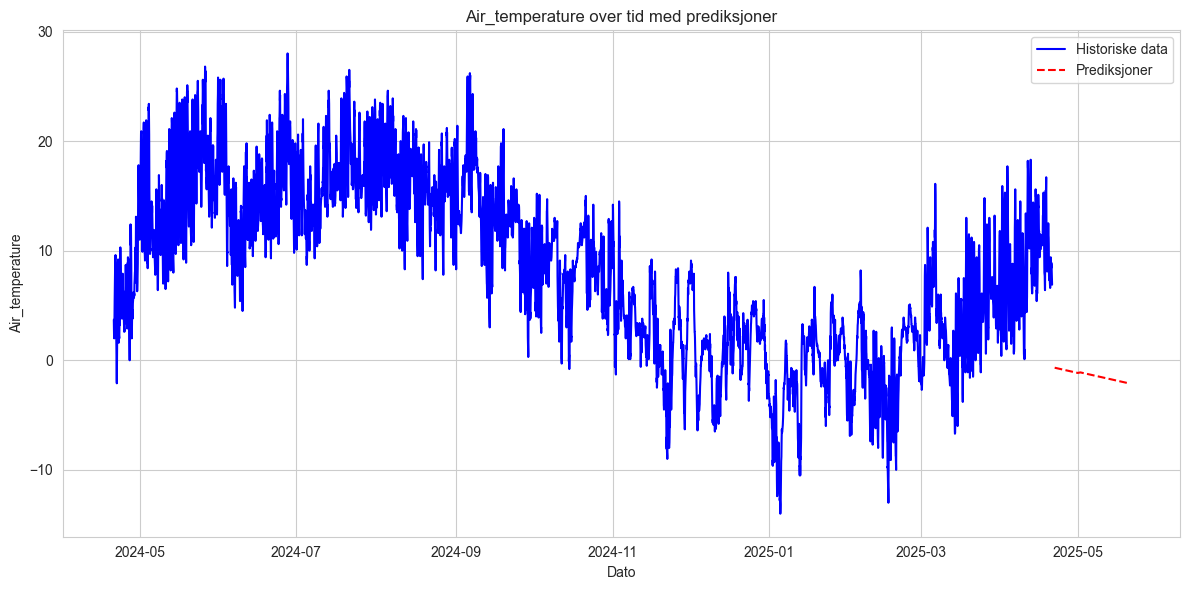

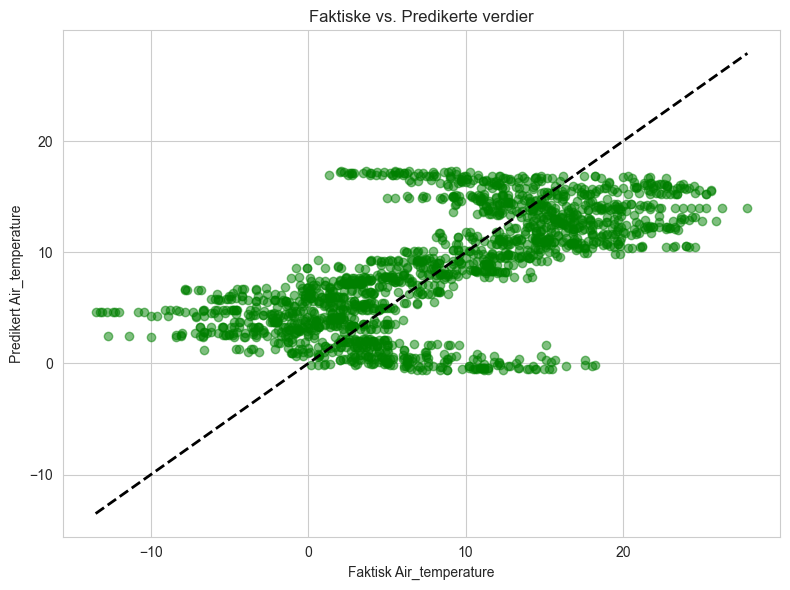

C:\Users\User\AppData\Local\Temp\ipykernel_12536\3389952496.py:96: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




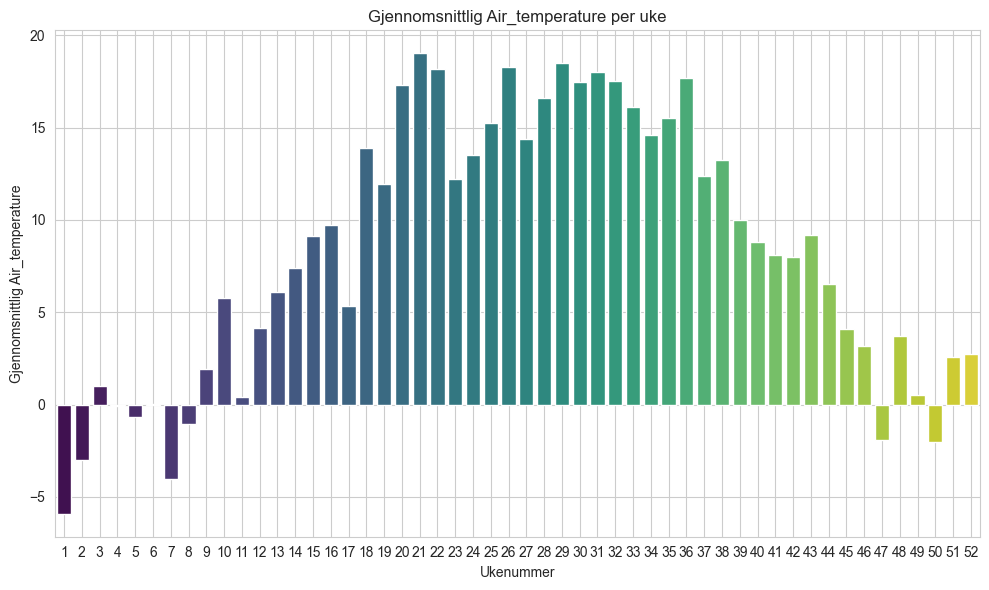

In [ ]:
def train_and_predict_weather(df, target_variable='air_temperature', future_days=30):

    
    df = df.copy()
    if 'date' not in df.columns:
        raise KeyError("The column 'date' is missing from the DataFrame. Please ensure the DataFrame contains a 'date' column.")
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    if df['date'].isnull().any():
        raise ValueError("Some entries in the 'date' column could not be converted to datetime. Please check the data.")
    df = df.set_index('date')
    df['day_of_year'] = df.index.dayofyear
    df['year'] = df.index.year
    df['month'] = df.index.month
    
    features = ['day_of_year', 'year', 'month']
    if target_variable not in df.columns:
        raise ValueError(f"Målvariabel '{target_variable}' finnes ikke i DataFrame.")
    
    df = df[features + [target_variable]].dropna()
    
    # Splitter data i trenings- og testsett
    X = df[features]
    y = df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tren lineær regresjonsmodell
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Sjekker ytelse på testsettet
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Prediksjoner for fremtidige datoer
    last_date = df.index.max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')
    future_df = pd.DataFrame(index=future_dates)
    future_df['day_of_year'] = future_df.index.dayofyear
    future_df['year'] = future_df.index.year
    future_df['month'] = future_df.index.month
    future_predictions = model.predict(future_df[features])
    
    predictions = pd.DataFrame({
        'date': future_dates,
        target_variable: future_predictions
    })


    # 1. Linjediagram: Historiske data og prediksjoner
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[target_variable], label='Historiske data', color='blue')
    plt.plot(predictions['date'], predictions[target_variable], label='Prediksjoner', color='red', linestyle='--')
    plt.title(f'{target_variable.capitalize()} over tid med prediksjoner')
    plt.xlabel('Dato')
    plt.ylabel(target_variable.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 2. Scatterplot: Faktiske vs. predikerte verdier i testsett
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title('Faktiske vs. Predikerte verdier')
    plt.xlabel(f'Faktisk {target_variable.capitalize()}')
    plt.ylabel(f'Predikert {target_variable.capitalize()}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 3. Søylediagram: Gjennomsnittlig ukentlig verdi
    weekly_avg = df.groupby(df.index.isocalendar().week)[target_variable].mean()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=weekly_avg.index, y=weekly_avg.values, palette='viridis')
    plt.title(f'Gjennomsnittlig {target_variable.capitalize()} per uke')
    plt.xlabel('Ukenummer')
    plt.ylabel(f'Gjennomsnittlig {target_variable.capitalize()}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
 
    return model, predictions

df_hourly = fetch_hourly_data(client_id, station_id, start_date, end_date)
df = prepare_weather_data(df_hourly)
model, predictions = train_and_predict_weather(df, target_variable='air_temperature', future_days=30)